# Bayesian Neural Network Pipeline for LIAR Dataset


## Load and Preprocess Data

In [ ]:
!pip install pyro-ppl


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import ClippedAdam

In [ ]:
def load_and_preprocess(path):
    columns = [
        'id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts', 'context']
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    label_map = {'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}
    df['label'] = df['label'].map(label_map)
    metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
    df[metadata_cols] = df[metadata_cols].fillna('unknown')
    return df

train_df = load_and_preprocess('train.tsv')
valid_df = load_and_preprocess('valid.tsv')
test_df = load_and_preprocess('test.tsv')

## Encode metadata


In [ ]:
metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
label_encoders = {}
for col in metadata_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], valid_df[col], test_df[col]])
    le.fit(combined)
    label_encoders[col] = le
    for df in [train_df, valid_df, test_df]:
        df[col + '_enc'] = le.transform(df[col])

In [ ]:
credit_cols = [
    'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts']
for df in [train_df, valid_df, test_df]:
    df[credit_cols] = df[credit_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

## Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class LIARDataset(Dataset):
    def __init__(self, df):
        self.texts = list(df['statement'])
        self.metadata = df[[col + '_enc' for col in metadata_cols] + credit_cols].values
        self.labels = list(df['label'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'metadata': torch.tensor(self.metadata[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## BERT Embedding + BNN

In [ ]:
class BNNClassifier(PyroModule):
    def __init__(self, bert_dim, meta_dim, hidden_dim, output_dim):
        super().__init__()

        class FrozenBERT(nn.Module):
            def __init__(self):
                super().__init__()
                self.model = BertModel.from_pretrained('bert-base-uncased')
                self.model.eval()
                for p in self.model.parameters():
                    p.requires_grad = False

            def forward(self, input_ids, attention_mask):
                with torch.no_grad():
                    return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        self.bert_model = FrozenBERT()

        input_dim = bert_dim + meta_dim
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., .5).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., .5).expand([hidden_dim]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](hidden_dim, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., .5).expand([output_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., .5).expand([output_dim]).to_event(1))

    def forward(self, input_ids, attention_mask, metadata, labels=None):
      bert_output = self.bert_model(input_ids, attention_mask)
      x = torch.cat((bert_output, metadata), dim=1)
      x = F.relu(self.fc1(x))
      logits = self.fc2(x)

      with pyro.plate("data", x.shape[0]):
        pyro.sample("obs", dist.Categorical(logits=logits), obs=labels)  # ok
      return logits

## Prepare Dataloaders

In [ ]:
from sklearn.preprocessing import MinMaxScaler

all_meta = [col + '_enc' for col in metadata_cols] + credit_cols
scaler = MinMaxScaler()
scaler.fit(train_df[all_meta])
for df in [train_df, valid_df, test_df]:
    df[all_meta] = scaler.transform(df[all_meta])


In [ ]:
train_dataset = LIARDataset(train_df)
valid_dataset = LIARDataset(valid_df)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

## Pyro Guide, Optimizer, and SVI

In [ ]:
from pyro.infer import TraceMeanField_ELBO

bert_dim = 768
meta_dim = len(metadata_cols) + len(credit_cols)
hidden_dim = 128
output_dim = 6

model = BNNClassifier(bert_dim, meta_dim, hidden_dim, output_dim)
guide = AutoDiagonalNormal(model)
optimizer = ClippedAdam({'lr': 1e-3})
svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO())

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Training Loop

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pyro")


In [ ]:
batch = next(iter(train_loader))
logits = model(
    batch['input_ids'],
    batch['attention_mask'],
    batch['metadata'],
    batch['label']
)
print("Logits range:", logits.min().item(), logits.max().item())


Logits range: -48.12839126586914 53.389373779296875


In [ ]:
model.eval()
with torch.no_grad():
    logits = model(
        batch['input_ids'],
        batch['attention_mask'],
        batch['metadata']
    )
    print("Logits:", logits)
    print("Min:", logits.min().item(), "Max:", logits.max().item())

Logits: tensor([[ 26.1303, -18.2171, -25.6216,  32.5156, -14.0218,  30.3386],
        [  5.5869,  -8.7486, -11.6058,  -9.9130, -20.7903,   0.4660],
        [ 15.2554, -17.5801,   5.8122,  14.5404,  -4.5678,  44.4064],
        [ 25.2850,  11.0010, -18.2811,  26.6287,  21.4338,  19.9179],
        [ -6.5535, -34.7466, -11.4522,  -3.1176, -12.7629,  40.3994],
        [ 19.9180, -32.9395,  15.6490,   6.9178,   4.0941,  37.5981],
        [  1.9346, -23.2174,   8.2411,  23.0861,  -8.1069,  12.4378],
        [ 13.3916, -11.6203, -11.2690,  -1.5239, -12.0226,   9.6703]])
Min: -34.746585845947266 Max: 44.40641403198242


In [ ]:
from pyro import poutine
from pyro.infer.autoguide import AutoDiagonalNormal

model_for_guide = poutine.block(model, hide=["obs"])
guide = AutoDiagonalNormal(model_for_guide)

svi = SVI(model_for_guide, guide, optimizer, loss=TraceMeanField_ELBO())

batch = next(iter(train_loader))
loss = svi.step(
    batch['input_ids'],
    batch['attention_mask'],
    batch['metadata'],
    batch['label']
)
loss_per_sample = loss / batch['input_ids'].size(0)
print(f"ELBO Loss for 1 batch: {loss:.4f}")
print(f"Loss per sample: {loss_per_sample:.4f}")


ELBO Loss for 1 batch: 118405.7188
Loss per sample: 14800.7148


In [ ]:
from tqdm import tqdm

best_val_loss = float('inf')
patience = 3
patience_counter = 0
num_epochs = 20


def train_epoch(dataloader, epoch_num=None):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch_num}", leave=False)
    for i, batch in progress_bar:
        loss = svi.step(
            batch['input_ids'],
            batch['attention_mask'],
            batch['metadata'],
            batch['label']
        )
        loss /= batch['input_ids'].size(0)
        epoch_loss += loss
        progress_bar.set_postfix(loss=epoch_loss / (i + 1))
    return epoch_loss / len(dataloader)

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(train_loader, epoch)

    model.eval()
    val_loss = 0
    for batch in valid_loader:
        loss = svi.evaluate_loss(
            batch['input_ids'],
            batch['attention_mask'],
            batch['metadata'],
            batch['label']
        )
        loss /= batch['input_ids'].size(0)
        val_loss += loss
    val_loss /= len(valid_loader)

    print(f"Epoch {epoch}  Train Loss: {train_loss:.4f} |  Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_bnn_model.pt")
        print(" New best model saved.")
    else:
        patience_counter += 1
        print(f" No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(" Early stopping triggered.")
        break


Epoch 1  Train Loss: 7843.6637 |  Val Loss: 2716.4509
 New best model saved.


Epoch 2  Train Loss: 868.2880 |  Val Loss: 109.9997
 New best model saved.


Epoch 3  Train Loss: 38.0483 |  Val Loss: 13.7511
 New best model saved.


Epoch 4  Train Loss: 11.1847 |  Val Loss: 10.1823
 New best model saved.


Epoch 5  Train Loss: 10.0158 |  Val Loss: 9.7084
 New best model saved.


Epoch 6  Train Loss: 9.8620 |  Val Loss: 9.8615
 No improvement. Patience: 1/3


Epoch 7  Train Loss: 9.8326 |  Val Loss: 9.7795
 No improvement. Patience: 2/3


Epoch 8  Train Loss: 9.8324 |  Val Loss: 9.6697
 New best model saved.


Epoch 9  Train Loss: 9.7845 |  Val Loss: 9.9280
 No improvement. Patience: 1/3


Epoch 10  Train Loss: 9.7595 |  Val Loss: 9.8236
 No improvement. Patience: 2/3


Epoch 11  Train Loss: 9.8710 |  Val Loss: 9.7227
 No improvement. Patience: 3/3
 Early stopping triggered.


In [ ]:
model.load_state_dict(torch.load("best_bnn_model.pt"))

<All keys matched successfully>

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

def evaluate_bnn(model, guide, dataloader, n_samples=10):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metadata = batch['metadata']
        labels = batch['label']

        logits_mc = []

        for _ in range(n_samples):
            guide_trace = pyro.poutine.trace(guide).get_trace(
                input_ids, attention_mask, metadata
            )
            replayed_model = pyro.poutine.replay(model, trace=guide_trace)

            with torch.no_grad():
                logits = replayed_model(input_ids, attention_mask, metadata)
                probs = F.softmax(logits, dim=-1)
                logits_mc.append(probs)

        mean_probs = torch.stack(logits_mc).mean(dim=0)
        preds = mean_probs.argmax(dim=1)

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1


In [ ]:
val_acc, val_f1 = evaluate_bnn(model, guide, valid_loader, n_samples=10)
print(f"BNN Validation Accuracy: {val_acc:.4f}")
print(f"BNN Validation F1 Score: {val_f1:.4f}")


BNN Validation Accuracy: 0.1659
BNN Validation F1 Score: 0.1689


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

def evaluate_bnn_with_uncertainty(model, guide, dataloader, n_samples=10):
    model.eval()
    all_preds, all_labels, all_entropies, all_variances, all_confidences = [], [], [], [], []

    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metadata = batch['metadata']
        labels = batch['label']

        probs_mc = []

        for _ in range(n_samples):
            guide_trace = pyro.poutine.trace(guide).get_trace(input_ids, attention_mask, metadata)
            replayed_model = pyro.poutine.replay(model, trace=guide_trace)

            with torch.no_grad():
                logits = replayed_model(input_ids, attention_mask, metadata)
                probs = F.softmax(logits, dim=-1)
                probs_mc.append(probs)

        probs_mc = torch.stack(probs_mc)
        mean_probs = probs_mc.mean(dim=0)
        preds = mean_probs.argmax(dim=1)

        confidences = mean_probs.max(dim=1).values

        entropies = torch.tensor([entropy(p.cpu().numpy()) for p in mean_probs])

        variances = probs_mc.var(dim=0).mean(dim=1)

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_confidences.extend(confidences.tolist())
        all_entropies.extend(entropies.tolist())
        all_variances.extend(variances.tolist())

    return all_preds, all_labels, all_confidences, all_entropies, all_variances


In [ ]:
preds, labels, confidences, entropies, variances = evaluate_bnn_with_uncertainty(model, guide, valid_loader, n_samples=10)


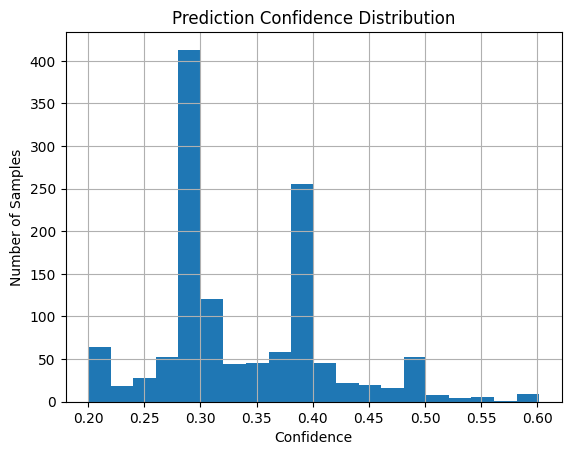

In [ ]:
plt.hist(confidences, bins=20)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

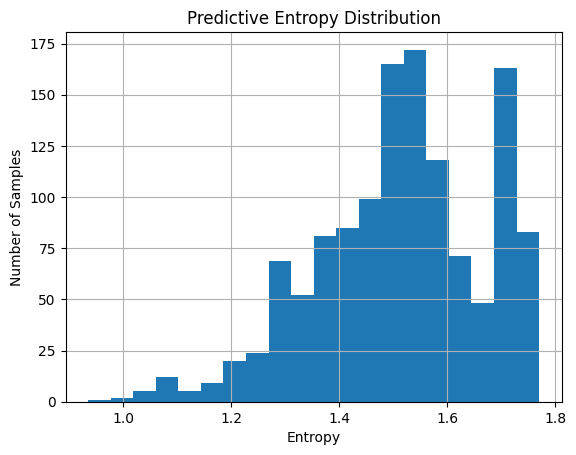

In [ ]:
plt.hist(entropies, bins=20)
plt.title("Predictive Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

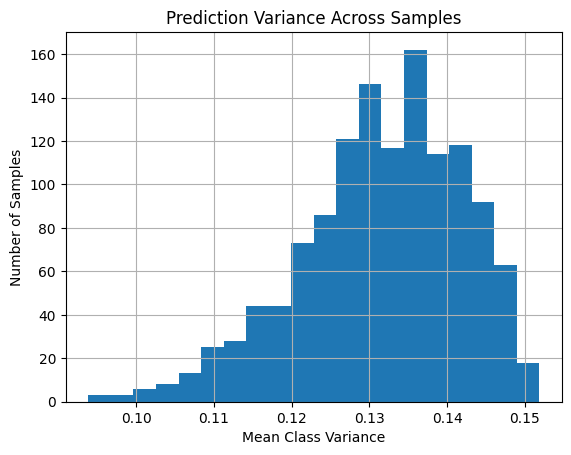

In [ ]:
plt.hist(variances, bins=20)
plt.title("Prediction Variance Across Samples")
plt.xlabel("Mean Class Variance")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

- model is highly uncertain about almost every prediction.
- in a 6-class classification task, random uniform confidence = ~0.167.
the model isn’t far above that.

- the models output distribution is nearly uniform

- the model has confidently learned to be uncertain

# Deterministic Classifier

In [ ]:
class DeterministicClassifier(nn.Module):
    def __init__(self, bert_dim, meta_dim, hidden_dim, output_dim):
        super().__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        for p in self.bert_model.parameters():
            p.requires_grad = False
        self.bert_model.eval()

        self.fc1 = nn.Linear(bert_dim + meta_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids, attention_mask, metadata):
        with torch.no_grad():
            bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        x = torch.cat((bert_output, metadata), dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
model = DeterministicClassifier(768, meta_dim, 128, 6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def train_epoch_det(dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])
        loss = loss_fn(logits, batch['label'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [ ]:
batch = next(iter(train_loader))

model.eval()

with torch.no_grad():
    logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, batch['label'])

print(f" Deterministic model loss (single batch): {loss.item():.4f}")



 Deterministic model loss (single batch): 1.8050


## Traning Loop

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    avg_loss = train_epoch_det(train_loader)
    print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}")


Epoch 1 Completed - Avg Loss: 1.7240
Epoch 2 Completed - Avg Loss: 1.6877
Epoch 3 Completed - Avg Loss: 1.6747


## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['label'].cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1


In [ ]:
acc, f1 = evaluate(model, valid_loader)
print(f"Deterministic Validation Accuracy: {acc:.4f}")
print(f"Deterministic Validation Macro F1: {f1:.4f}")


Deterministic Validation Accuracy: 0.2726
Deterministic Validation Macro F1: 0.2666
